In [1]:
%cd ./drive/MyDrive/Github/Anime/animeface_dataset/animeface-character-dataset/thumb/

/content/drive/MyDrive/Github/Anime/animeface_dataset/animeface-character-dataset/thumb


In [43]:
import os 
from glob import glob 
import numpy as np 
from PIL import Image 
import torch, torchvision 
import torch.nn as nn 
from torchvision import transforms 
from torchvision.models import vgg19 
from torch.utils.data import DataLoader 
from sklearn.metrics import classification_report
from torch.utils.tensorboard import summary 
import matplotlib.pyplot as plt
import json 
from tqdm import tqdm 


In [24]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)
torch.manual_seed(0)
np.random.seed(0)

cpu


In [45]:
class Transform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            "train": transforms.Compose([
                                         transforms.RandomResizedCrop(resize, scale=(.5, 1.0)),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean, std)
            ]), 
            "val": transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, phase, img):
        return self.data_transform[phase](img)

class MyDataSet(object):
    def __init__(self, resize, mean, std):
        self.files = []
        self.labels = []
        self.label2index = {}
        self.transform = Transform(resize, mean, std)
        self.count = 0

        self._load()
        self._vocab()

    def _load(self):
        root_path = "*/"
        for root in glob(root_path):
            self.count = 0
            for f in glob(root+"*.png"):
                if self.count == 1:
                    break 
                label = f.split("/")[0].split("_")[-1]
                self.files.append(f)
                self.labels.append(label)
                self.count += 1
                if label not in self.label2index:
                    self.label2index[label] = len(self.label2index)

    def _vocab(self):
        labels = []
        for l in self.labels:
            labels.append(self.label2index[l])
        self.labels = labels 

    def __getitem__(self, idx):
        img = Image.open(self.files[idx])
        label = self.labels[idx]
        img_tensor = self.transform("train", img)
        label_tensor = torch.tensor(label)
        return img_tensor, label_tensor 

    def __len__(self):
        return len(self.files)


RESIZE = 224 
MEAN = (.485, .456, .406)
STD = (.229, .224, .225)
mydata = MyDataSet(RESIZE, MEAN, STD)

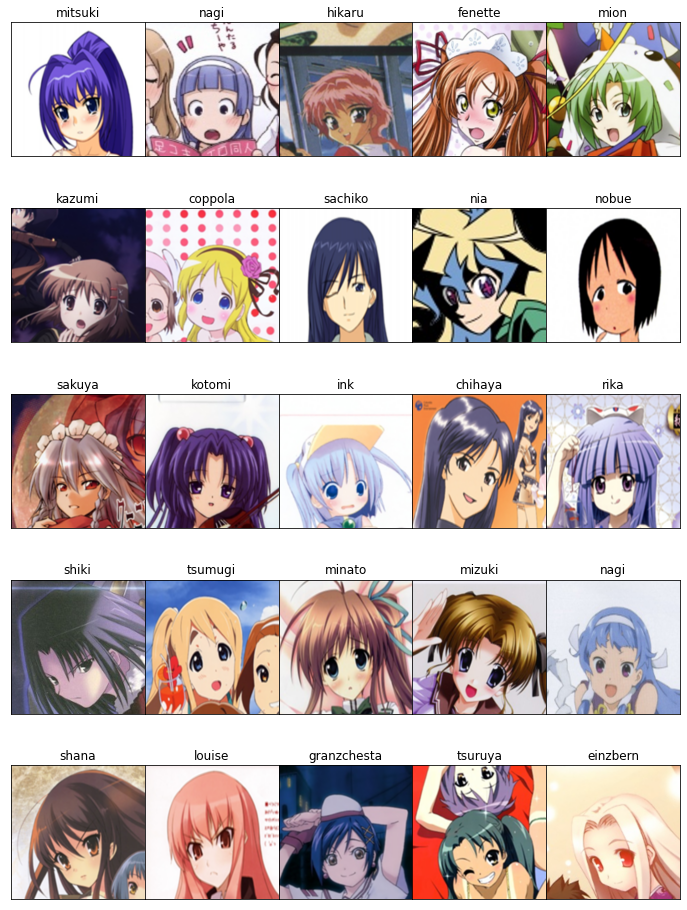

In [31]:
def show_img(img_file):
    fig, axes = plt.subplots(5, 5, figsize=(12, 12))
    ax = axes.ravel()
    for i in range(25):
        a = np.random.randint(0, len(img_file), 1)[0]
        img = Image.open(img_file[a]).resize((1080, 1080))
        name = img_file[a].split("/")[0].split("_")[-1]
        ax[i].imshow(img)
        ax[i].set_title(name)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.subplots_adjust(wspace=0, hspace=0, top=1.2)
    plt.show()

show_img(mydata.files)

In [46]:
train_dl = DataLoader(dataset=mydata, batch_size=32, shuffle=True, drop_last=True)

In [39]:
class Classifier(nn.Module):
    def __init__(self, n_classes):
        super(Classifier, self).__init__()
        self.vgg = vgg19(pretrained=True)
        for w in self.vgg.parameters():
            w.requires_grad = False 
        self.fc = nn.Linear(1000, n_classes)

    def forward(self, x):
        y = self.vgg(x)
        y = self.fc(y)
        return y 
net = Classifier(len(mydata.label2index))

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [50]:
def trainer(img, label, net, criterion, optimizer):
    output = net(img)
    loss = criterion(output, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def show_losses(losses):
    plt.figure(figsize=(12, 5))
    plt.plot(np.arange(losses).tolist(), losses)
    plt.title("vgg19 train losses")
    plt.show()

def train(train, net, num_epoch, print_loss=100, plot_loss=150, lr=0.001):
    net.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
    show_plot_loss = []

    for e in range(num_epoch):
        net.train()
        print_losses, plot_losses, total_loss = [], [], []
        for i, (img, label) in enumerate(tqdm(train)):
            img = img.to(device)
            label = label.to(device)
            loss = trainer(img, label, net, criterion, optimizer)
      
            total_loss.append(loss)
            print_losses.append(loss)
            plot_losses.append(loss)

            if print_loss%i==0:
                a = np.mean(np.array(print_losses))
                print("\n")
                print(f"iteration:{i} | train | loss{a:.5f}\n")
                print_losses = []
            if plot_loss%i==0:
                show_plot_loss.append(np.mean(np.array(plot_losses)))
                plot_losses = []

        print(f"epoch: {e+1} | train | loss:{np.mean(np.array(total_loss))}\n")
        total_loss = []
    
    show_losses(show_plot_loss)
    torch.save(net.state_dict(), f"classifier{num_epoch}.pth")

In [51]:
train(train_dl, net, 1)

 20%|██        | 1/5 [00:23<01:33, 23.35s/it]

iteration:0 | train | loss5.83272


 40%|████      | 2/5 [00:48<01:12, 24.31s/it]

iteration:1 | train | loss5.96730


 60%|██████    | 3/5 [01:14<00:50, 25.08s/it]

iteration:2 | train | loss6.04991


 80%|████████  | 4/5 [01:38<00:24, 24.78s/it]

iteration:3 | train | loss6.20629


 80%|████████  | 4/5 [02:01<00:30, 30.33s/it]


KeyboardInterrupt: ignored